In [52]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math as mp

Lecture de notre image et seuillage.

154 50


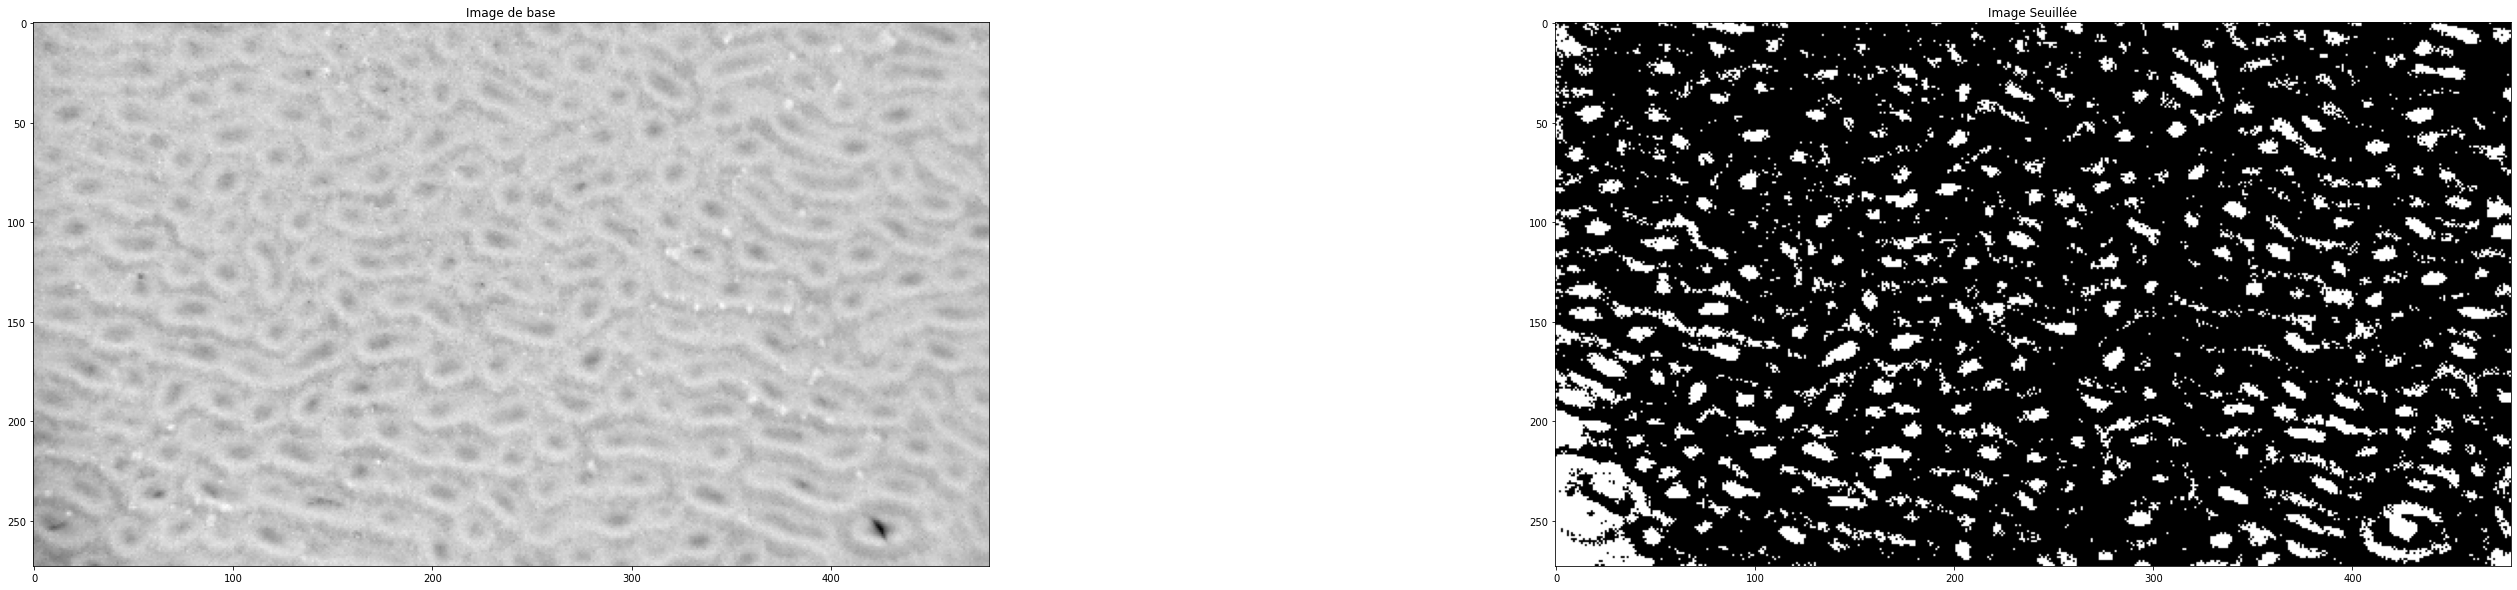

In [63]:
image = cv2.imread('perovskyte.png',0)
imageS = cv2.threshold(image,125,255,cv2.THRESH_BINARY_INV) # On applique un seuillage inverse pour avoir le fond en noir. Le seuillage vaut 250, si un pixels>250 on le met à 255
imageSS = imageS[1] # on récupère l'image du seuillage
u = np.max(image)
v = np.min(image)
print(u,v)
plt.figure(figsize=(50,10))

plt.subplot(121)
plt.title("Image de base")
plt.imshow(image,'gray') # affichage de l'image I en niveau de gris

plt.subplot(122)
plt.title("Image Seuillée")
plt.imshow(imageSS,'gray') # affichage de l'image I en niveau de gris
plt.show() # déclenche l'affichage

Création des marqueurs :

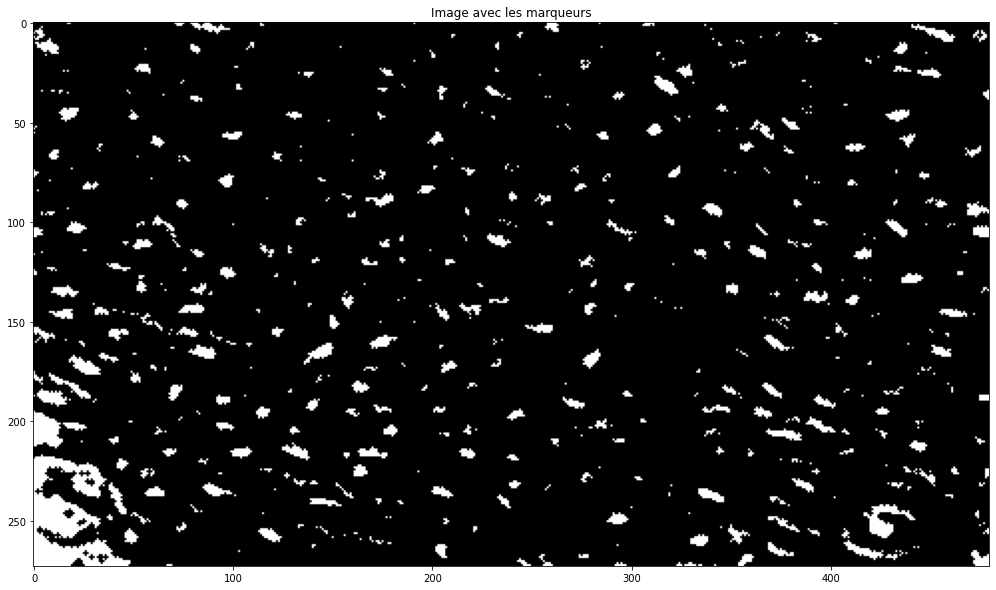

In [64]:
S = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)) #On créé une ellipse comme élément structurant car on veut avoir un points dans chaque smarties
imageM = cv2.erode(imageSS, S, iterations = 1) #on l'érode  avec l'image structurant

plt.figure(figsize=(50,10))

plt.subplot(121)
plt.title("Image avec les marqueurs")
plt.imshow(imageM,'gray') # affichage de l'image I en niveau de gris

Labellisation de mes marqueurs + du fond

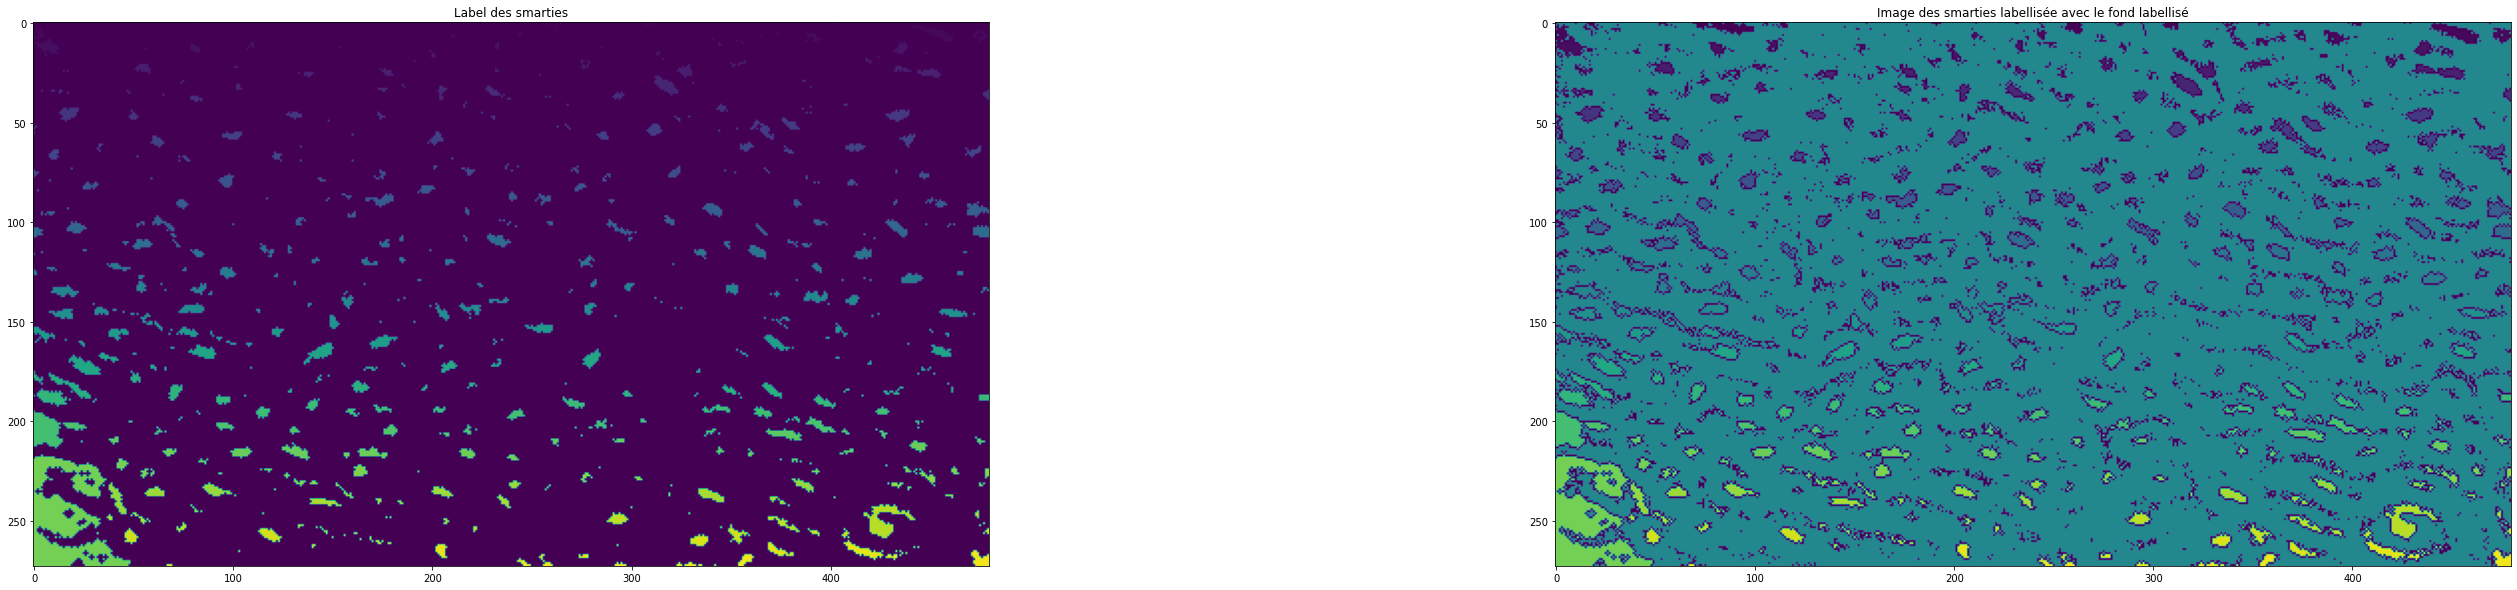

In [66]:
imageML = cv2.connectedComponents(imageM) #on labélise nos marqueur : le fond n'est pas encore labellisé
imageMLL = imageML[1] # on récupère l'image labellisée

imageF = cv2.threshold(image,125,np.max(imageMLL)+1,cv2.THRESH_BINARY) # on fait un seuillage ou cette fois ci le blanc est le fond et vaut 33(derniere valeur du label d'avant + 1) et le seuillage vaut 250
imageFond = imageF[1]

imageMarqueurs = imageFond+imageMLL # On additionne les 2 seuillages

plt.figure(figsize=(50,10))

plt.subplot(121)
plt.title("Label des smarties")
plt.imshow(imageML[1]) # affichage de l'image I en niveau de gris

plt.subplot(122)
plt.title("Image des smarties labellisée avec le fond labellisé")
plt.imshow(imageMarqueurs) # affichage de l'image I en niveau de gris
plt.show() # déclenche l'affichage

Création de la carte des distances

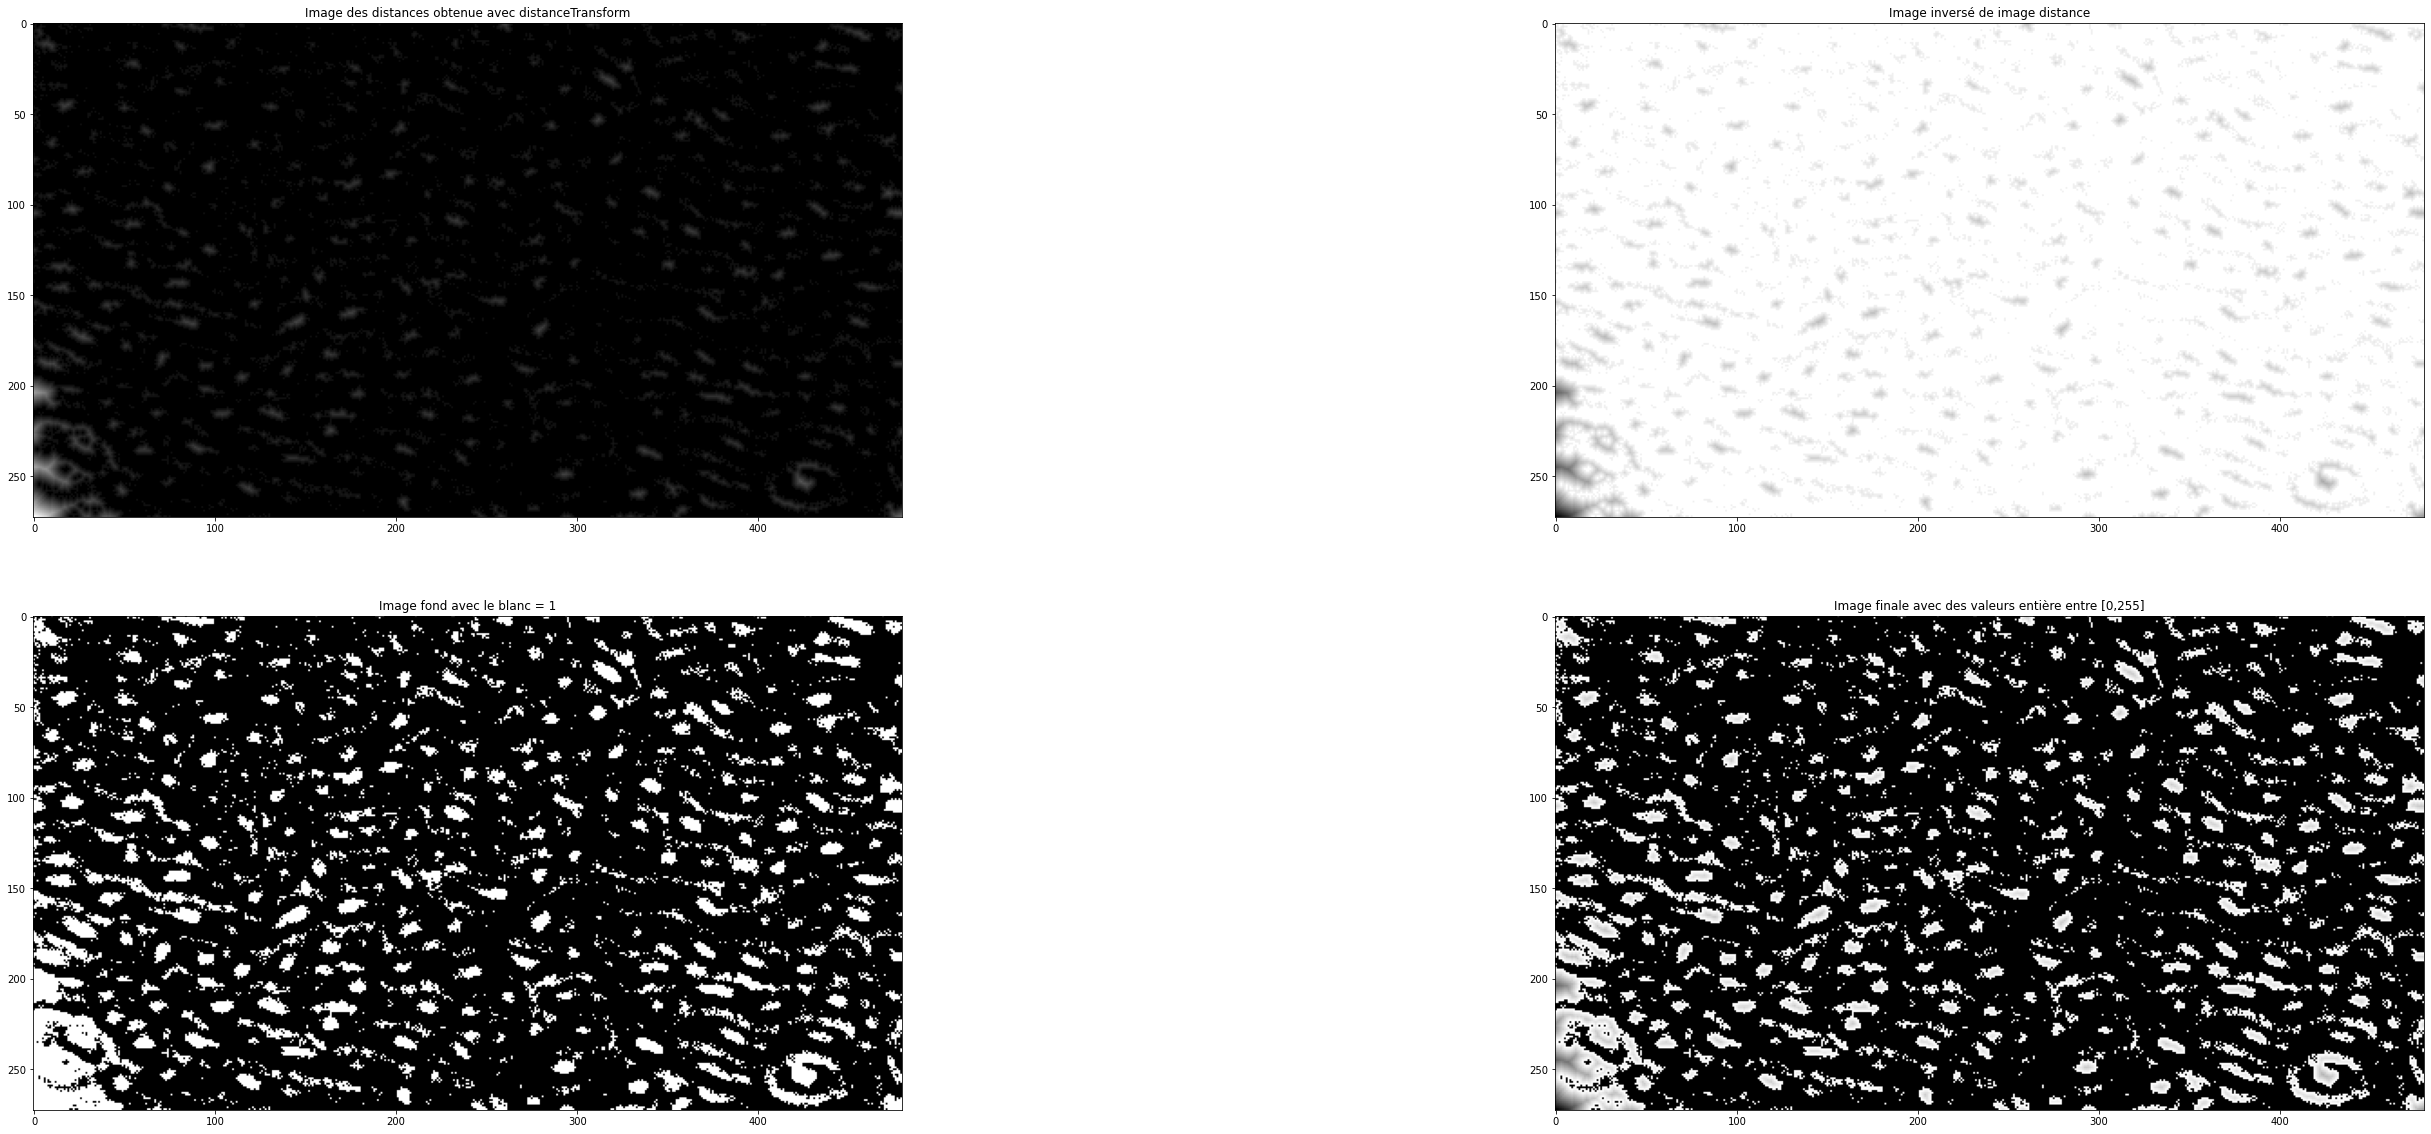

In [68]:
imageD = cv2.distanceTransform(imageSS,cv2.DIST_L2,3,cv2.CV_32F) #On créer les distances avec la fonction
u = np.max(imageD) # On la normalise
imageN = imageD * (255/u)

imageI = 255 - imageN #On l'inverse pour avoir le noir au milieux (le noir==0 donc la plus forte prioritée)

imageF = cv2.threshold(image,125,1,cv2.THRESH_BINARY_INV)  # on refait le même seuillage qu'avant mais cette fois ci le blanc vaut 1
ImageFin = imageI * imageF[1] # On multiplie notre image des distances inversé par l'image seuillée, le fond passe donc au noir et on ne change rien d'autre

#On normalise l'image obtenue pour l'avoir entre [0,255]
u = np.max(ImageFin)
Imagetempo = ImageFin * (255/u)

#On la met sous forme uint8 donc la matrice ne contient maintenant que des entiers (avant elle pouvait contenir des float)
imageDistFin = np.uint8(Imagetempo)
max2 = np.max(imageDistFin)
min2 = np.min(imageDistFin)



plt.figure(figsize=(50,20))

plt.subplot(221)
plt.title("Image des distances obtenue avec distanceTransform")
plt.imshow(imageD,'gray') # affichage de l'image I en niveau de gris

plt.subplot(222)
plt.title("Image inversé de image distance")
plt.imshow(imageI,'gray') # affichage de l'image I en niveau de gris

plt.subplot(223)
plt.title("Image fond avec le blanc = 1")
plt.imshow(imageF[1],'gray') # affichage de l'image I en niveau de gris

plt.subplot(224)
plt.title("Image finale avec des valeurs entière entre [0,255]")
plt.imshow(imageDistFin,'gray') # affichage de l'image I en niveau de gris
plt.show() # déclenche l'affichage


LPE :

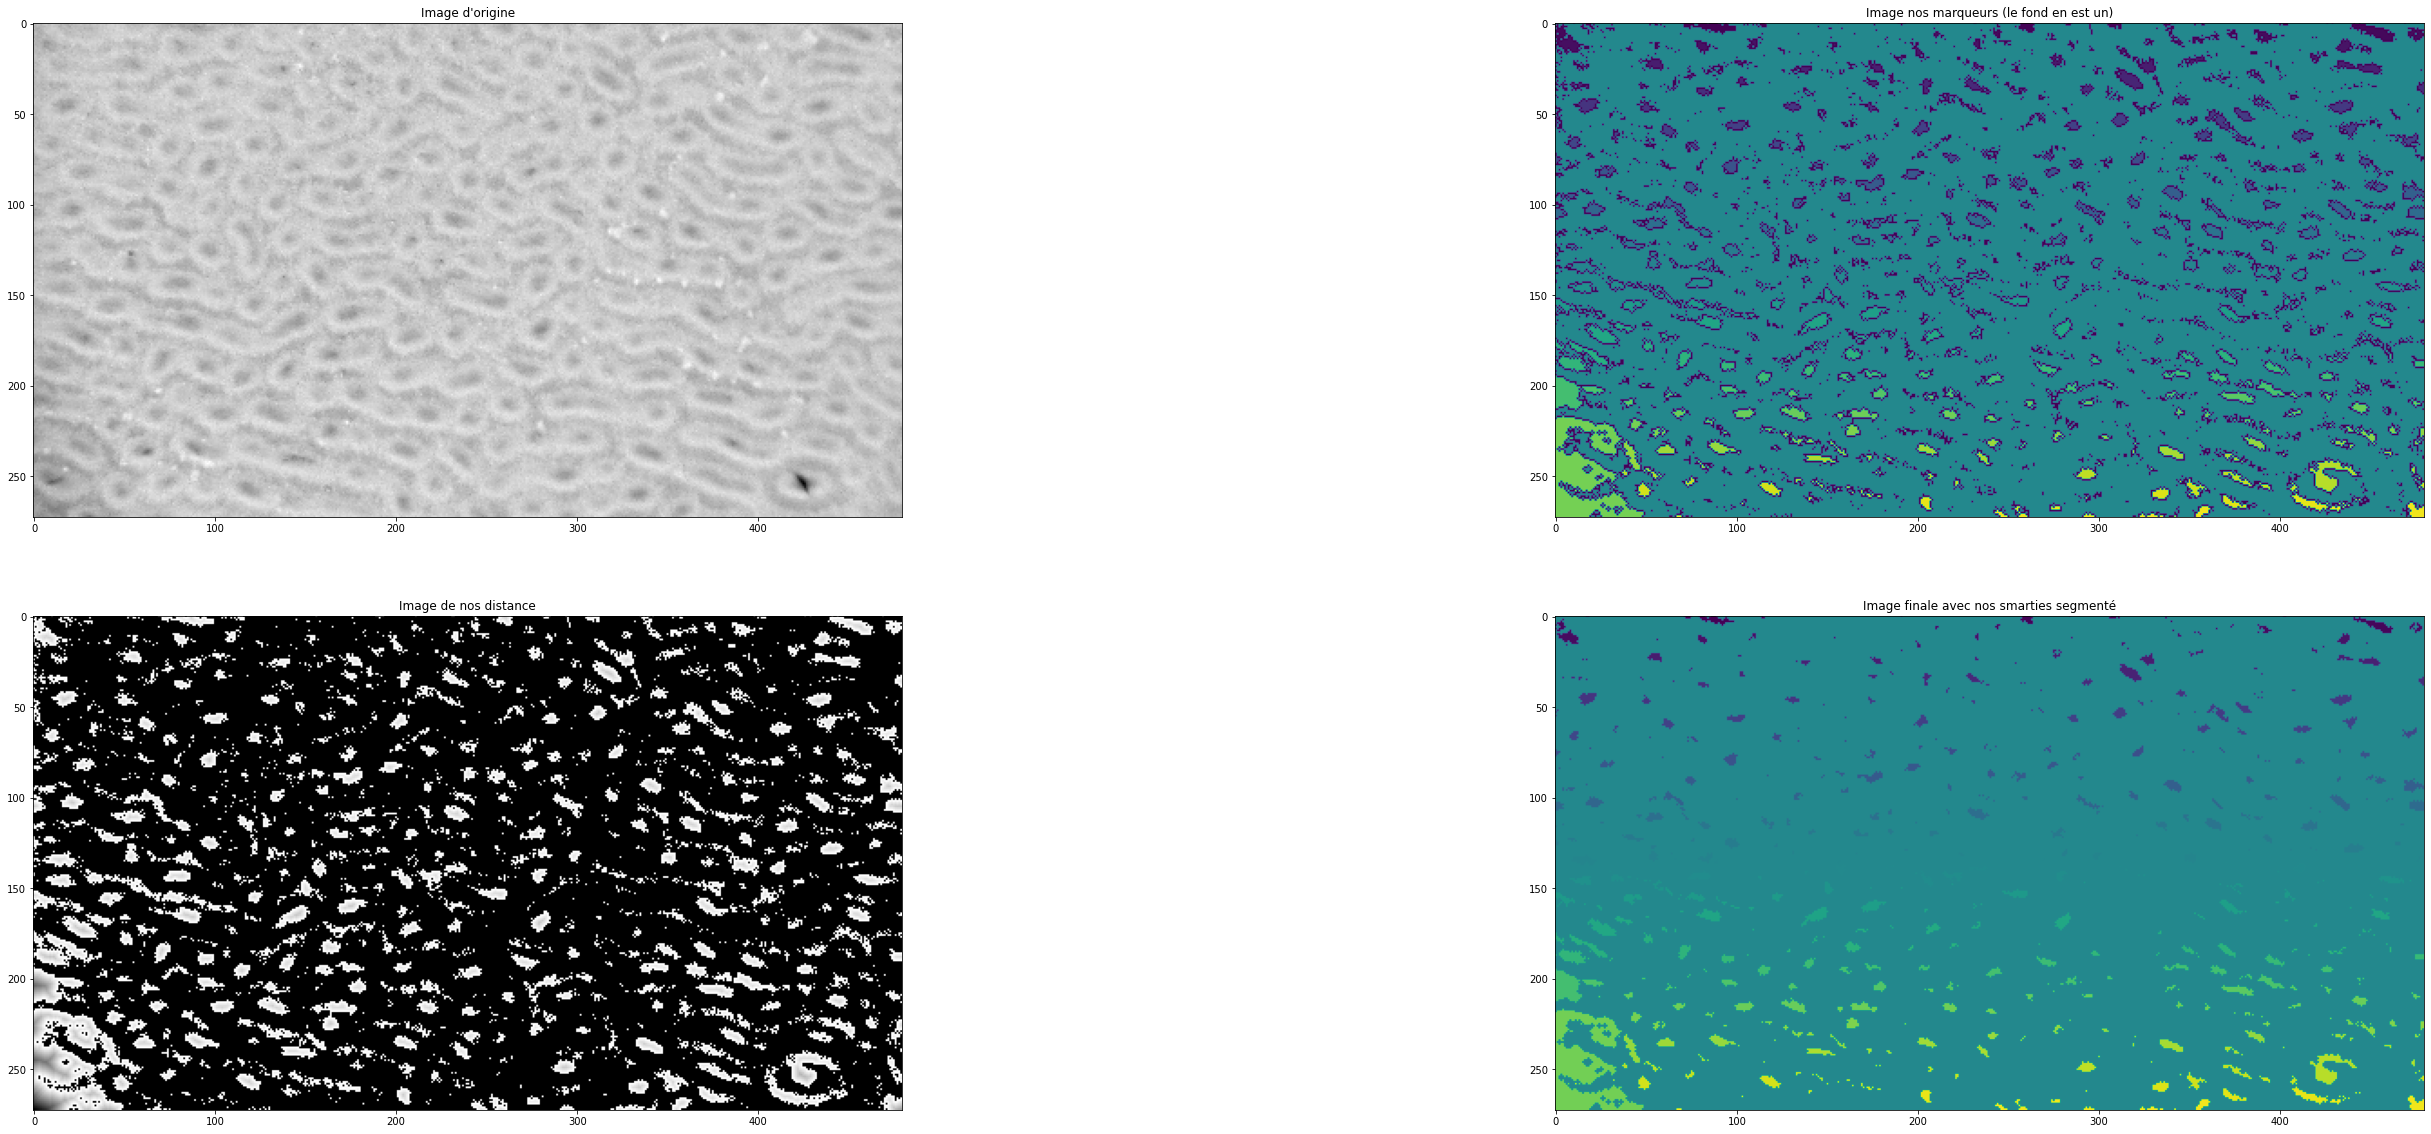

In [69]:
T = np.copy(imageMarqueurs)

CoordLigne = []
CoordColonne = []
for i in range(256):
    CoordLigne.append([])
    CoordColonne.append([])

taille = imageMarqueurs.shape
TailleLigne = taille[0]
TailleColonne = taille[1]

ImageEnregistree = {0,50,100,150,200,255}

for i in range(TailleLigne):
    for j in range(TailleColonne):
        if imageMarqueurs[i][j]!=0 :
            CoordLigne[imageDistFin[i][j]].append(i) # on parcours tous nos marqueurs et on les rangent selon leur priorité dans CoordLigne et CoordColonne
            CoordColonne[imageDistFin[i][j]].append(j)

min = 0
while min!=256 : # Tant que l'on a pas parcouru toutes les colonnes de CoordLigne donc tous les niveaux de priorité
    if CoordLigne[min]: # Si il y a des pixels à traiter dans la la colonne de priorités min on fait ce qui suit sinon on augment min et au passe a la priorité suivante
        while CoordLigne[min]: # Tant qu'il y a des pixels à traiter dans la colonne de priorité min
            i = CoordLigne[min].pop(0)
            j = CoordColonne[min].pop(0) # on récupère les 2 corrdonées de notre prixels

            # On regarde ses 4 voisins, si un voisin n'a pas de label, on lui attribut le label du pixel récupérer et on range les coordonnées de se nouveau pixel selon leur priorité dans CoordLigne et CoordColonne
            if(i<TailleLigne-1):
                if T[i+1][j]==0:
                    T[i+1][j]=T[i][j]
                    u = imageDistFin[i+1][j] # Si la prioritée du nouveaux pixel est inférieur à min on lui donne une nouvelle prioriée : min (car on ne repassera pas dans les colonnes qui ont déjà été traité entièrement)
                    CoordLigne[np.max([u,min])].append(i+1)
                    CoordColonne[np.max([u,min])].append(j)
                
            if(j<TailleColonne-1):
                if T[i][j+1]==0:
                    T[i][j+1]=T[i][j]
                    u = imageDistFin[i][j+1]
                    CoordLigne[np.max([u,min])].append(i)
                    CoordColonne[np.max([u,min])].append(j+1)

            if(i!=0) :
                if T[i-1][j]==0:
                    T[i-1][j]=T[i][j]
                    u = imageDistFin[i-1][j]
                    CoordLigne[np.max([u,min])].append(i-1)
                    CoordColonne[np.max([u,min])].append(j)

            if(j!=0):
                if T[i][j-1]==0:
                    T[i][j-1]=T[i][j]
                    u = imageDistFin[i][j-1]
                    CoordLigne[np.max([u,min])].append(i)
                    CoordColonne[np.max([u,min])].append(j-1)
    else : 
        if min in ImageEnregistree :
            im1 = plt.imsave("{}.png".format(min), T)
        min+=1


plt.figure(figsize=(50,20))


plt.subplot(221)
plt.title("Image d'origine")
plt.imshow(image,'gray') # affichage de l'image I en niveau de gris


plt.subplot(222)
plt.title("Image nos marqueurs (le fond en est un)")
plt.imshow(imageMarqueurs) # affichage de l'image I en niveau de gris

plt.subplot(223)
plt.title("Image de nos distance")
plt.imshow(imageDistFin,'gray') # affichage de l'image I en niveau de gris

plt.subplot(224)

plt.title("Image finale avec nos smarties segmenté")
plt.imshow(T) # affichage de l'image I en niveau de gris
plt.show() # déclenche l'affichage